In [72]:
# add folders to Python's search space
import os, sys
from pathlib import Path
script_dir = Path(os.path.dirname(os.path.abspath('')))
module_dir = str(script_dir)
sys.path.insert(0, module_dir + '/modules')
print(module_dir)

# import the rest of the modules
%matplotlib nbagg
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt
import arch
import pandas as pd
DTYPE = 'float32'

C:\Users\pinak\Documents\GitHub\var-al


<IPython.core.display.Javascript object>


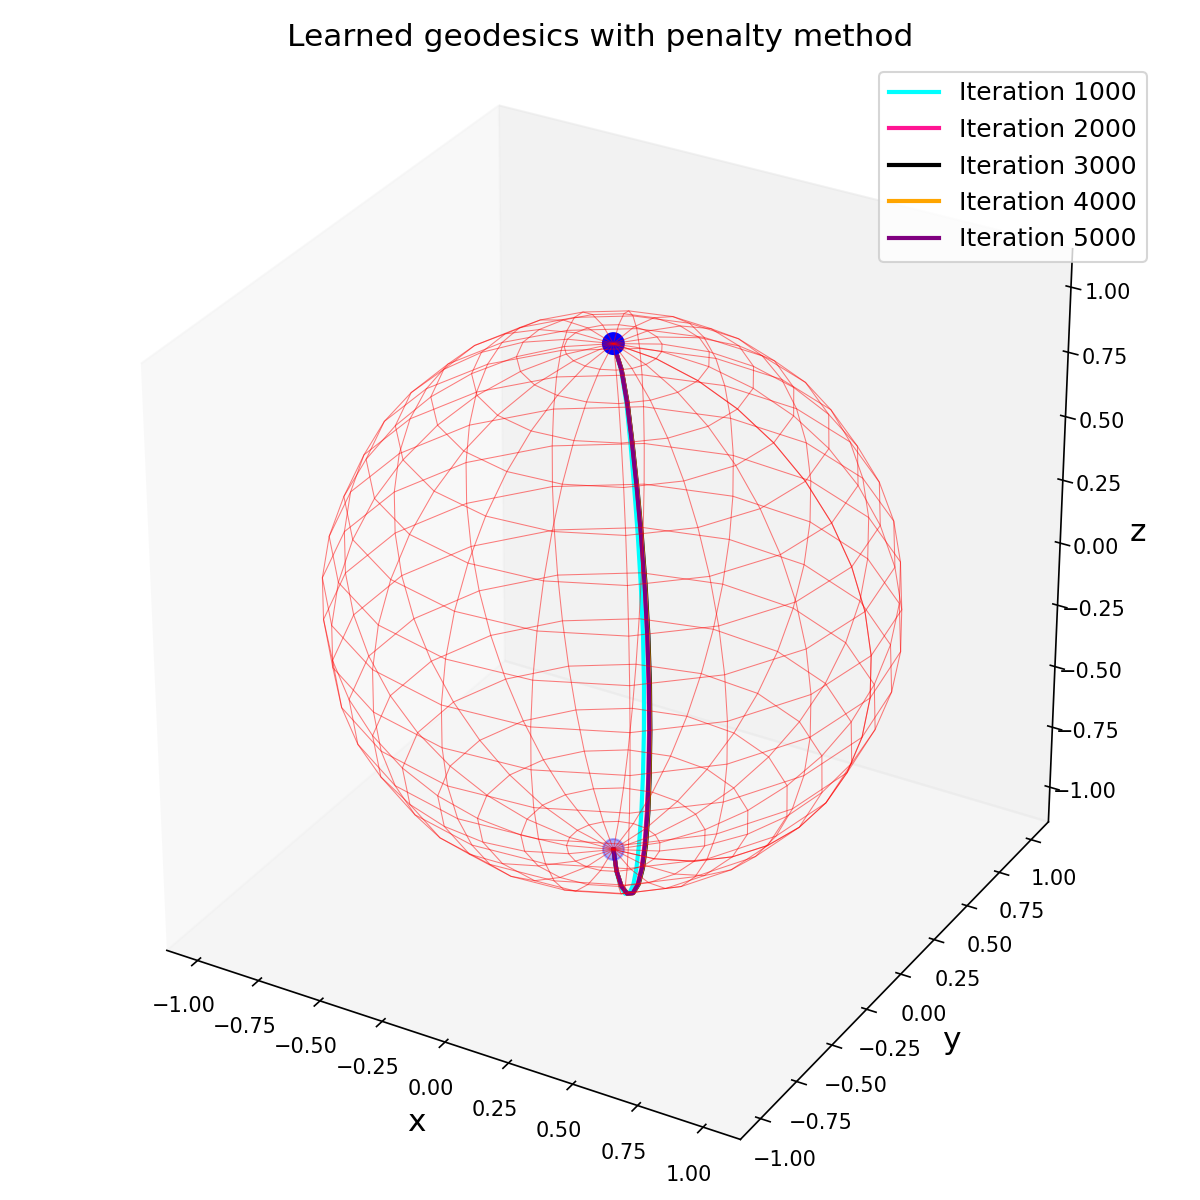

In [77]:
# load learned solutions
net_p = arch.VanillaNet(50, 3, DTYPE, name="sphere-geodesic")
net_p.load_weights('../data/sphere-geodesic-inf/{}'.format(net_p.name)).expect_partial()

# net_al = arch.VanillaNet(50, 3, DTYPE, name='helicoid-al')
# net_al.load_weights('../data/helicoid-al/{}'.format(net_al.name)).expect_partial()

# set up plotting parameters
scale = 0
xlabel_size = ylabel_size = 15 + scale
tick_size = 10 + scale
legend_size = 15 + scale
title_size = 15 + scale
cbar_tick_size = 10 + scale
line_color = "darkgrey"

# plot solutions
def plot_solutions(filename, resolution=50):
    fig = plt.figure(figsize=(8, 8))
    ax_p = fig.add_subplot(111, projection='3d')
  
    # plotting params  
    ax_p.tick_params(axis='both', which='major', labelsize=tick_size)
    ax_p.tick_params(axis='both', which='minor', labelsize=tick_size)
    ax_p.set_title('Learned geodesics with penalty method', fontsize=title_size)
    ax_p.set_xlabel('x', fontsize=xlabel_size)
    ax_p.set_ylabel('y', fontsize=ylabel_size)
    ax_p.set_zlabel('z', fontsize=ylabel_size)
    

    p = np.linspace(0., 2.*np.pi, num=resolution, endpoint=True).astype(DTYPE)
    t = np.linspace(0., np.pi, num=resolution, endpoint=True).astype(DTYPE)
    
    p0, t0 = np.meshgrid(p, t)
    p1 = np.ones_like(t)
   
    
    
    c, s = np.cos(t0), np.sin(t0)
    c1, s1 = np.cos(t), np.sin(t)
    xs, ys, zs = s*np.cos(p0), s*np.sin(p0), c
    
    ax_p.set_box_aspect((np.ptp(xs), np.ptp(ys), np.ptp(zs))) 
    ax_p.plot_wireframe(xs, ys, zs, color='red', alpha=0.5, linewidth=0.5)
    ax_p.scatter([0, 0], [0, 0], [1, -1], color='blue', s=100)
    net_p.load_weights('../data/sphere-geodesic-inf/{}_10000'.format(net_p.name)).expect_partial()
    z_p = net_p(t.reshape(-1, 1)).numpy()
    phi = z_p.flatten()
    ax_p.plot(s1*np.cos(phi), s1*np.sin(phi), c1, color='cyan', linewidth=2., label='Iteration 1000')
    net_p.load_weights('../data/sphere-geodesic-inf/{}_20000'.format(net_p.name)).expect_partial()
    z_p = net_p(t.reshape(-1, 1)).numpy()
    phi = z_p.flatten()
    ax_p.plot(s1*np.cos(phi), s1*np.sin(phi), c1, color='deeppink', linewidth=2., label='Iteration 2000')
    net_p.load_weights('../data/sphere-geodesic-inf/{}_30000'.format(net_p.name)).expect_partial()
    z_p = net_p(t.reshape(-1, 1)).numpy()
    phi = z_p.flatten()
    ax_p.plot(s1*np.cos(phi), s1*np.sin(phi), c1, color='black', linewidth=2., label='Iteration 3000')
    net_p.load_weights('../data/sphere-geodesic-inf/{}_40000'.format(net_p.name)).expect_partial()
    z_p = net_p(t.reshape(-1, 1)).numpy()
    phi = z_p.flatten()
    ax_p.plot(s1*np.cos(phi), s1*np.sin(phi), c1, color='orange', linewidth=2., label='Iteration 4000')
    net_p.load_weights('../data/sphere-geodesic-inf/{}_50000'.format(net_p.name)).expect_partial()
    z_p = net_p(t.reshape(-1, 1)).numpy()
    phi = z_p.flatten()
    ax_p.plot(s1*np.cos(phi), s1*np.sin(phi), c1, color='purple', linewidth=2., label='Iteration 5000')
    ax_p. grid(False)
    ax_p.legend(fontsize=legend_size-3)

    fig.tight_layout()
    plt.savefig('{}.png'.format(filename), dpi=300)
    plt.show()

plot_solutions(filename='../plots/sphere-geodesic-inf', resolution=20)

In [59]:
t = np.linspace(0., np.pi, num=60, endpoint=True).astype(DTYPE)
z_p = net_p(t.reshape(-1, 1)).numpy()

In [60]:
z_p

array([[ 1.0000618 ],
       [-0.8177382 ],
       [-0.8759725 ],
       [-0.8836944 ],
       [-0.89133334],
       [-0.8989532 ],
       [-0.90560466],
       [-0.9111208 ],
       [-0.91473454],
       [-0.9173694 ],
       [-0.9194658 ],
       [-0.9211638 ],
       [-0.9220497 ],
       [-0.92310333],
       [-0.92357767],
       [-0.9241371 ],
       [-0.92425317],
       [-0.92458713],
       [-0.92470133],
       [-0.92506003],
       [-0.9250866 ],
       [-0.9251635 ],
       [-0.92590797],
       [-0.92634726],
       [-0.9264824 ],
       [-0.92699057],
       [-0.92778116],
       [-0.92783934],
       [-0.9287001 ],
       [-0.9289738 ],
       [-0.9295331 ],
       [-0.92957324],
       [-0.9303843 ],
       [-0.93068624],
       [-0.9307484 ],
       [-0.9311091 ],
       [-0.9311687 ],
       [-0.93122655],
       [-0.9315846 ],
       [-0.93171215],
       [-0.93203574],
       [-0.93217653],
       [-0.93260705],
       [-0.93379354],
       [-0.9348135 ],
       [-0

In [8]:
t

array([0.        , 0.10649467, 0.21298933, 0.319484  , 0.42597866,
       0.5324733 , 0.638968  , 0.74546266, 0.8519573 , 0.958452  ,
       1.0649467 , 1.1714413 , 1.277936  , 1.3844306 , 1.4909253 ,
       1.59742   , 1.7039146 , 1.8104093 , 1.916904  , 2.0233986 ,
       2.1298933 , 2.236388  , 2.3428826 , 2.4493773 , 2.555872  ,
       2.6623666 , 2.7688613 , 2.875356  , 2.9818506 , 3.0883453 ,
       3.19484   , 3.3013346 , 3.4078293 , 3.514324  , 3.6208186 ,
       3.7273133 , 3.833808  , 3.9403026 , 4.0467973 , 4.153292  ,
       4.2597866 , 4.3662815 , 4.472776  , 4.579271  , 4.6857653 ,
       4.79226   , 4.8987546 , 5.0052495 , 5.111744  , 5.218239  ,
       5.3247333 , 5.431228  , 5.5377226 , 5.6442175 , 5.750712  ,
       5.857207  , 5.9637012 , 6.070196  , 6.1766906 , 6.2831855 ],
      dtype=float32)